# Topology  plus 1D epigenomic tracks based module finder from HiC data {GM12878}

## HiC data analysis for edge extraction

In [1]:
import argparse
import shutil
import h5py
import numpy as np
import pandas as pd
import cooler
import cooltools
import cooltools.lib.plotting
from cooltools.lib.numutils import adaptive_coarsegrain, interp_nan
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import json
import pickle
from tqdm import tqdm
import os, subprocess
import bioframe
import pyBigWig
import warnings
import sklearn
from sklearn.decomposition import PCA
import sys
import seaborn as sns
import pickle
## from concurrent.futures import ProcessPoolExecutor, as_completed
## import multiprocessing
## func imports


### a. Using mapped reads (BAM files) to create contact pairs

Pairtools pipeline (mapped reads to contact matrix)

In [ ]:
##convert 200M (40GBs) coverage reads to pairs format (~1hr)

In [4]:
!pairtools parse -c /work/magroup/asachan2/genomic_hubs/data/hg19.autosomal.chrom.sizes -o GM12878_Rao_200m.pairs.gz --drop-sam /work/magroup/asachan2/genomic_hubs/data/GM12878/4DNFISDRIE2G.bam

In [ ]:
##8M coverage reads (~2mins)

In [5]:
!pairtools parse -c /work/magroup/asachan2/genomic_hubs/data/hg19.autosomal.chrom.sizes -o GM12878_Rao_8m.pairs.gz --drop-sam /work/magroup/asachan2/genomic_hubs/data/GM12878/8M_coverage/4DNFINZZ7XEW.bam

In [ ]:
##sort for de-duplication (~15 mins for 200M reads)

In [3]:
!pairtools sort --nproc 5 -o GM12878_Rao_8m.sorted.pairs.gz GM12878_Rao_8m.pairs.gz

In [2]:
!pairtools sort --nproc 5 -o GM12878_Rao_200m.sorted.pairs.gz tmp/GM12878_Rao_200m.pairs.gz

In [ ]:
##de-duplicate (~20 mins for 200m reads)

In [8]:
!pairtools dedup -o GM12878_Rao_8m.nodups.pairs.gz tmp/GM12878_Rao_8m.sorted.pairs.gz

In [9]:
!gunzip GM12878_Rao_8m.nodups.pairs.gz

In [3]:
!pairtools dedup -o GM12878_Rao_200m.nodups.pairs.gz GM12878_Rao_200m.sorted.pairs.gz

In [4]:
!gunzip GM12878_Rao_200m.nodups.pairs.gz

### b. Creating cooler file from contact pairs

In [5]:
## clean up code for additional pairs that give bad input error during cooler creation 

chrom_sizes_file = '/work/magroup/asachan2/genomic_hubs/data/hg19.autosomal.chrom.sizes'
input_file = 'GM12878_Rao_200m.nodups.pairs'
output_file = 'GM12878_Rao_200m.filtered.pairs'

## filter out bad pairs (func from analysis_pipeline)
filter_pairs(chrom_sizes_file, input_file, output_file)

In [7]:
import pandas as pd
df = pd.read_csv('/Users/Akanksha/MaGroup/Genomic Hubs/workflow/data/GM12878/4DN Data Portal_hg19/gene_chrom_bin_num_hg19_gm12878.txt', delimiter='\t')
sort_df = df.sort_values(by=['chrom', 'txStart'])
#save sorted df to file
sort_df.to_csv('/Users/Akanksha/MaGroup/Genomic Hubs/workflow/data/GM12878/4DN Data Portal_hg19/gene_chrom_bin_num_hg19_gm12878_sorted.txt', sep='\t', index=False)

In [3]:
!cooler cload pairs -c1 2 -p1 3 -c2 4 -p2 5 --assembly hg19 /work/magroup/asachan2/genomic_hubs/data/hg19.autosomal.chrom.sizes:100000 GM12878_Rao_200m.filtered.pairs GM12878_Rao_200m.100kb.cool

INFO:cooler.create:Writing chunk 0: /work/magroup/asachan2/genomic_hubs/tmp2m36mfrt.multi.cool::0
INFO:cooler.create:Creating cooler at "/work/magroup/asachan2/genomic_hubs/tmp2m36mfrt.multi.cool::/0"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
INFO:cooler.create:Writing pixels
INFO:cooler.create:Writing indexes
INFO:cooler.create:Writing info
INFO:cooler.create:Writing chunk 1: /work/magroup/asachan2/genomic_hubs/tmp2m36mfrt.multi.cool::1
INFO:cooler.create:Creating cooler at "/work/magroup/asachan2/genomic_hubs/tmp2m36mfrt.multi.cool::/1"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
INFO:cooler.create:Writing pixels
INFO:cooler.create:Writing indexes
INFO:cooler.create:Writing info
INFO:cooler.create:Writing chunk 2: /work/magroup/asachan2/genomic_hubs/tmp2m36mfrt.multi.cool::2
INFO:cooler.create:Creating cooler at "/work/magroup/asachan2/genomic_hubs/tmp2m36mfrt.multi.cool::/2"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bi

In [4]:
!cooler balance -p 10 GM12878_Rao_200m.100kb.cool

INFO:cooler.cli.balance:Balancing "GM12878_Rao_200m.100kb.cool"
INFO:cooler.balance:variance is 1871969.4621466738
INFO:cooler.balance:variance is 514781.8926356739
INFO:cooler.balance:variance is 176817.69028649371
INFO:cooler.balance:variance is 78077.5708182415
INFO:cooler.balance:variance is 35730.65891948752
INFO:cooler.balance:variance is 18164.728608223697
INFO:cooler.balance:variance is 9259.278276755364
INFO:cooler.balance:variance is 5023.237544361767
INFO:cooler.balance:variance is 2700.0655082632256
INFO:cooler.balance:variance is 1515.6477074142276
INFO:cooler.balance:variance is 841.9432008287222
INFO:cooler.balance:variance is 482.4271647249048
INFO:cooler.balance:variance is 274.13677412344754
INFO:cooler.balance:variance is 159.20969523966016
INFO:cooler.balance:variance is 91.93600051017273
INFO:cooler.balance:variance is 53.893145103931374
INFO:cooler.balance:variance is 31.47980036726636
INFO:cooler.balance:variance is 18.577630495935928
INFO:cooler.balance:variance

In [6]:
!cooler dump -b -t pixels --header --join -r chr3:10M-12M -r2 chr17 GM12878_Rao_200m.100kb.cool | head

chrom1	start1	end1	chrom2	start2	end2	count	balanced
chr3	10000000	10100000	chr17	500000	600000	1	0.00017911
chr3	10000000	10100000	chr17	1200000	1300000	1	0.000180061
chr3	10000000	10100000	chr17	2600000	2700000	1	0.000175123
chr3	10000000	10100000	chr17	3500000	3600000	1	0.000150043
chr3	10000000	10100000	chr17	5000000	5100000	1	0.000178285
chr3	10000000	10100000	chr17	6200000	6300000	1	0.000144167
chr3	10000000	10100000	chr17	6600000	6700000	1	0.000135981
chr3	10000000	10100000	chr17	7100000	7200000	1	0.00017322
chr3	10000000	10100000	chr17	8100000	8200000	1	0.000181723


In [7]:
## loading the cooler created from CLI processing above
#single res cool made from BAM file
cool_file = 'GM12878_Rao_200m.100kb.cool'
c = cooler.Cooler(cool_file)
resolution = c.binsize


In [4]:
##### load metadata (compartment scores) using pybigwig #####

bw_file = 'data/GM12878/4DNFIDPK7WFE_compartments.bw'
bw_gt = pyBigWig.open(bw_file) #bigwig files have multiple zoom levels, some match the resolution of the cooler file
intervals = bw_gt.intervals('chr3', start=0, end=2000000) #250k zoom level
#for interval in intervals:
#    print(interval)

##### load metadata (insulation score) using pybigwig #####

ins_file = 'data/GM12878/4DNFI62JTGEX_insulation_100kb.bw'
ins_gt = pyBigWig.open(ins_file)
intervals2 = ins_gt.intervals('chr3', start=0, end=2000000) #5kb zoom level
#for interval in intervals2:
#    print(interval)

Can load pre-processed cooler file from a database

In [3]:
####### loading cooler file at a specific resolution ########

cool_file = '/Users/Akanksha/MaGroup/Genomic Hubs/workflow/data/GM12878/4DN Data Portal_hg19/4DNFITRVKRPA.mcool'
resolution = 1000000 #(250kb: compartment resolution) (5kb/10kb: TAD resolution for 4/6 cutter restriction enzyme)
#loading 5kb res into jupyter requires mem = 128
c = cooler.Cooler(cool_file+'::/resolutions/'+str(resolution))

chromosome = 'chr1'
chrA_inter = 'chr1'
chrB_inter = 'chr2'
print(c.bins().fetch(chromosome))

      chrom      start        end        KR        VC   VC_SQRT    weight
0      chr1          0      10000       NaN  0.000000  0.000000       NaN
1      chr1      10000      20000       NaN  0.000000  0.000000       NaN
2      chr1      20000      30000       NaN  0.000000  0.000000       NaN
3      chr1      30000      40000       NaN  0.000614  0.021698       NaN
4      chr1      40000      50000       NaN  0.001228  0.030686       NaN
...     ...        ...        ...       ...       ...       ...       ...
24891  chr1  248910000  248920000  1.059333  1.242482  0.976181  0.020757
24892  chr1  248920000  248930000  0.946321  1.109885  0.922623  0.021811
24893  chr1  248930000  248940000  0.319384  0.342542  0.512557  0.059208
24894  chr1  248940000  248950000  0.052107  0.031921  0.156468       NaN
24895  chr1  248950000  248956422       NaN  0.000000  0.000000       NaN

[24896 rows x 7 columns]


### c. Pre-processing mcool file for extracting 3D genome features

In [20]:
####### Process M ########

M = c.matrix(balance=False).fetch(chromosome)[:] # adj matrix {fetch('chr3')[:] for region specific viz}
M_inter = c.matrix(balance=False).fetch(chrA_inter, chrB_inter)[:]

#chr specific: smoothing of matrix using adaptive coarsegraining (based on raw counts)
cg = adaptive_coarsegrain(c.matrix(balance=True).fetch(chromosome)[:],
                              c.matrix(balance=False).fetch(chromosome)[:],
                              cutoff=3, max_levels=8)
print(cg)
#save as npy object to load later
np.save(f"tmp/M_CG_{chromosome}.npy", cg)

#save as txt file to inspect matrix
#np.savetxt('tmp/M_CG.txt', cg, delimiter='\t')



/work/magroup/asachan2/genomic_hubs/cooltools/cooltools/lib/numutils.py:1376: RuntimeWarning: invalid value encountered in divide
  val_cur = ar_cur / armask_cur


[[       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 ...
 [       nan        nan        nan ... 0.11568357        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]]


chr1 : (0, 24896)
chr2 : (24896, 49116)
chr3 : (49116, 68946)
chr4 : (68946, 87968)
chr5 : (87968, 106122)
chr6 : (106122, 123203)
chr7 : (123203, 139138)
chr8 : (139138, 153652)
chr9 : (153652, 167492)
chr10 : (167492, 180872)
chr11 : (180872, 194381)
chr12 : (194381, 207709)
chr13 : (207709, 219146)
chr14 : (219146, 229851)
chr15 : (229851, 240051)
chr16 : (240051, 249085)
chr17 : (249085, 257411)
chr18 : (257411, 265449)
chr19 : (265449, 271311)
chr20 : (271311, 277756)
chr21 : (277756, 282427)
chr22 : (282427, 287509)
chrX : (287509, 303114)
chrY : (303114, 308837)


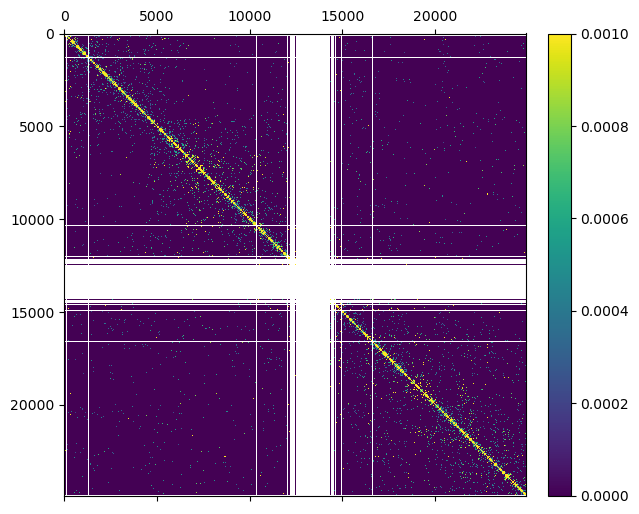

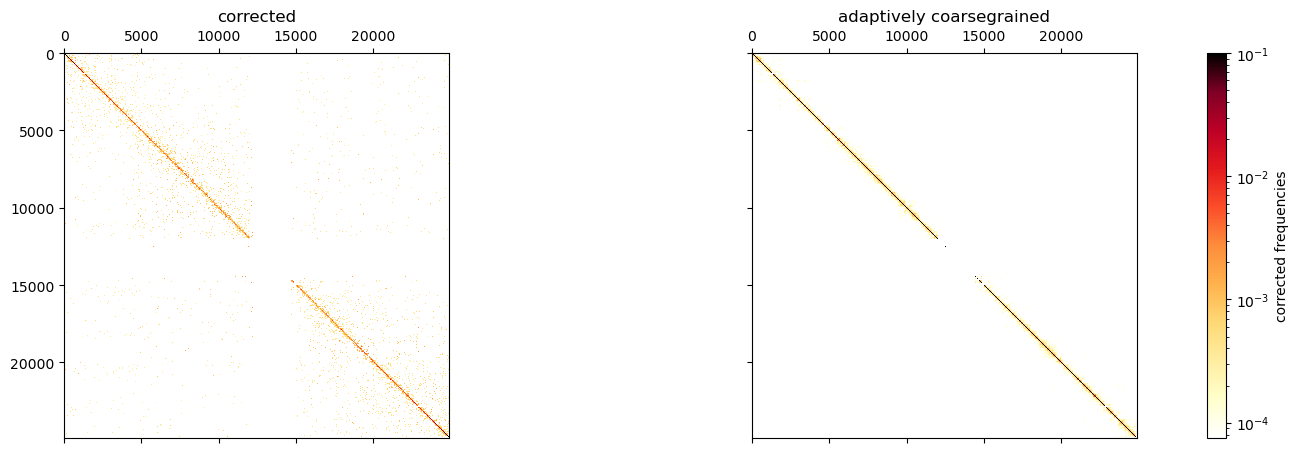

In [19]:
########## vis M (chr specific) matrices (raw, corrected, coarse-grained etc) ###########
#make a chromstarts list (utility)
chromstarts = []
for i in c.chromnames:
    print(f'{i} : {c.extent(i)}')
    chromstarts.append(c.extent(i)[0])

#vis matrices
f, ax = plt.subplots(
    figsize=(7,6))
im = ax.matshow(c.matrix(balance=True).fetch(chromosome)[:],vmax=0.001); plt.colorbar(im ,fraction=0.046, pad=0.04)
#ax.set(xticks=chromstarts, xticklabels=c.chromnames,
       #xlabel='position, chrom#', ylabel='position, bin#')
ax.xaxis.set_label_position('top')

#vis smoothed matrices
norm = LogNorm(vmax=0.1)
f, axs = plt.subplots(
    figsize=(18,5),
    nrows=1,
    ncols=2,
    sharex=True, sharey=True)

ax = axs[0]
im = ax.matshow(c.matrix(balance=True).fetch(chromosome)[:], cmap='fall', norm=norm)
ax.set_title('corrected')

ax = axs[1]
im2 = ax.matshow(cg, cmap='fall', norm=norm)
ax.set_title(f'adaptively coarsegrained')

plt.colorbar(im2, ax=axs, fraction=0.046, label='corrected frequencies')

### Additional bin filtering as defined in Rao et al 2014: 
Rows and
columns for which more than 30% of the entries were either undefined or zeros were removed from the matrix. These bins
were excluded from all further analyses involving the cluster tracks unless otherwise noted. We then took the logarithm of
each entry in the C matrix.  

To-Do: Whole genome visualisation:
Higlass viz (as matshow can't load 200M reads/ mills of interactions of a 10kb file for whole genome visualisation)

## Extracting topological features for edge creation

#### 1. O/E calculation

In [21]:
######### O/E edge calculation #########

#adaptively coarse-grained matrix is important to be used as input to get the O/E code to work, other matrices are too sparse/non-balanced to produce sane o/e matrices
o_e_log, OE_thresholded, expected, sums = get_oe_logtrans(cg[:], 1.5) #o/e of raw contact matrix, uses smoothed matrix as input

#print the number of non-zero elements in the O/E matrix
print(np.count_nonzero(o_e_log))
print(np.count_nonzero(OE_thresholded)) #change threshold acc to the number of edges you need for plotting purposes

#save as npy objects to load later
np.save('tmp/o_e_log.npy', o_e_log)
np.save('tmp/OE_thresholded.npy', OE_thresholded)
np.save('tmp/expected.npy', expected)


485849764
101406


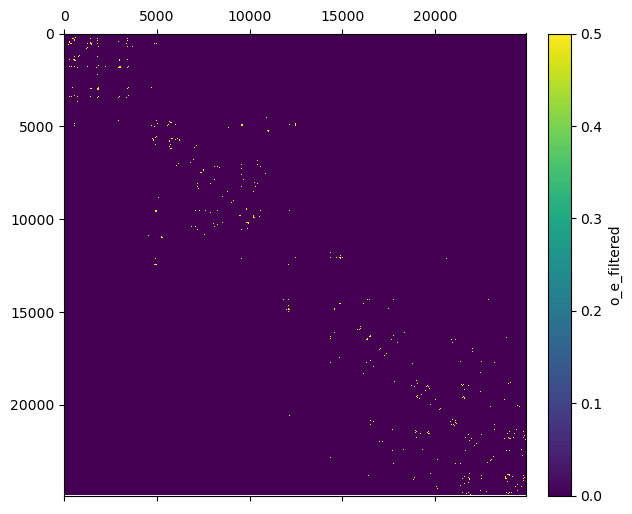

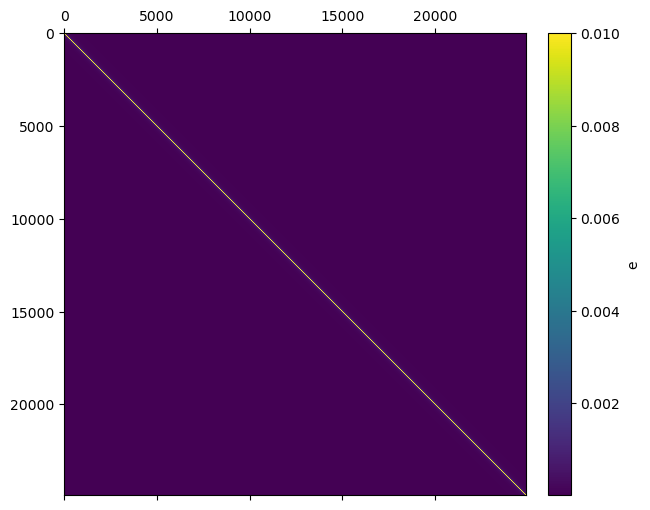

In [23]:
######### visualise matrices ########

#f, ax = plt.subplots(
#   figsize=(7,6))
#im = ax.matshow(o_e_log,vmax=5); plt.colorbar(im ,fraction=0.046, pad=0.04, label='o_e_log_transformed')
#ax.set(xticks=chromstarts, xticklabels=c.chromnames,
       #xlabel='position, chrom#', ylabel='position, bin#')
ax.xaxis.set_label_position('top')

#plot another oe matrix
f, ax = plt.subplots(
   figsize=(7,6))
im = ax.matshow(OE_thresholded,vmax=0.5); plt.colorbar(im ,fraction=0.046, pad=0.04, label='o_e_filtered')
ax.xaxis.set_label_position('top')

#plot E matrix too
f, ax = plt.subplots(
   figsize=(7,6))
im = ax.matshow(expected,vmax=0.01); plt.colorbar(im ,fraction=0.046, pad=0.04, label='e')
ax.xaxis.set_label_position('top')

#### 2. A/B compartment score

In [5]:
###### calc A/B scores to validate the contact maps at 250Kb ########

# load chromsizes
chromsizes = bioframe.fetch_chromsizes('hg19')
chromsizes = chromsizes.to_dict()
bins = c.bins().fetch(chromosome)[:] #select for each chr, pd dataframe
print(bins)
#e1 = get_A_B(o_e_log)
#e1_bigwig(bins, e1[0], chromsizes, 'e1.bw')


      chrom      start        end        KR        VC   VC_SQRT    weight
0      chr1          0      10000       NaN  0.000000  0.000000       NaN
1      chr1      10000      20000       NaN  0.000000  0.000000       NaN
2      chr1      20000      30000       NaN  0.000000  0.000000       NaN
3      chr1      30000      40000       NaN  0.000614  0.021698       NaN
4      chr1      40000      50000       NaN  0.001228  0.030686       NaN
...     ...        ...        ...       ...       ...       ...       ...
24891  chr1  248910000  248920000  1.059333  1.242482  0.976181  0.020757
24892  chr1  248920000  248930000  0.946321  1.109885  0.922623  0.021811
24893  chr1  248930000  248940000  0.319384  0.342542  0.512557  0.059208
24894  chr1  248940000  248950000  0.052107  0.031921  0.156468       NaN
24895  chr1  248950000  248956422       NaN  0.000000  0.000000       NaN

[24896 rows x 7 columns]


In [ ]:
### Node labeling by compartment score ###
#classify bins as A/B compartments to store as bin labels based on if e1 is positive or negative
bins['a/b'] = np.sign(e1[0]).flatten()
#covert -1 to B label and +1 to A label
bins['a/b'] = bins['a/b'].replace({-1:'B', 1:'A'})
print(bins)

#### 3. Load Sub-compartment annotations

In [6]:
### load gm12878 ground truth sub-comp scores
subcompartment_file = 'data/GM12878/GSE63525_GM12878_subcompartments.bed'
bins = get_subcompartments_intra(subcompartment_file, bins, resolution)
print(bins)


      chrom      start        end        KR        VC   VC_SQRT    weight  \
0      chr1          0      10000       NaN  0.000000  0.000000       NaN   
1      chr1      10000      20000       NaN  0.000000  0.000000       NaN   
2      chr1      20000      30000       NaN  0.000000  0.000000       NaN   
3      chr1      30000      40000       NaN  0.000614  0.021698       NaN   
4      chr1      40000      50000       NaN  0.001228  0.030686       NaN   
...     ...        ...        ...       ...       ...       ...       ...   
24891  chr1  248910000  248920000  1.059333  1.242482  0.976181  0.020757   
24892  chr1  248920000  248930000  0.946321  1.109885  0.922623  0.021811   
24893  chr1  248930000  248940000  0.319384  0.342542  0.512557  0.059208   
24894  chr1  248940000  248950000  0.052107  0.031921  0.156468       NaN   
24895  chr1  248950000  248956422       NaN  0.000000  0.000000       NaN   

      subcompartment  
0                  N  
1                  N  
2     

#### 4. Insulation score

In [27]:
##### insulation score at 10kb or 5kb #####

# load chromsizes
chromsizes = bioframe.fetch_chromsizes('hg19')
chromsizes = chromsizes.to_dict()
print(chromsizes)

bins = c.bins().fetch(chromosome)[:] #select for each chr
insulation = insulation_score(cg[:], windowsize=200000, res=resolution)
print(insulation)
#save insulation score as bigwig 
#ins_bigwig(bins, insulation, chromsizes, 'ins_200_100kb.bw')

{'chr1': 249250621, 'chr2': 243199373, 'chr3': 198022430, 'chr4': 191154276, 'chr5': 180915260, 'chr6': 171115067, 'chr7': 159138663, 'chr8': 146364022, 'chr9': 141213431, 'chr10': 135534747, 'chr11': 135006516, 'chr12': 133851895, 'chr13': 115169878, 'chr14': 107349540, 'chr15': 102531392, 'chr16': 90354753, 'chr17': 81195210, 'chr18': 78077248, 'chr19': 59128983, 'chr20': 63025520, 'chr21': 48129895, 'chr22': 51304566, 'chrX': 155270560, 'chrY': 59373566, 'chrM': 16571}
[1. 1. 1. ... 1. 1. 1.]


#### 5. Loop calls 

#### Peakachu calling loops

In [2]:
!python call_loops.py --resolution 10000 --infile /work/magroup/asachan2/genomic_hubs/peakachu/predicted_loops/GM12878-H3K27ac-chr2-scores.bedpe --outfile /work/magroup/asachan2/genomic_hubs/peakachu/predicted_loops/GM12878-H3K27ac-chr2-loops.bedpe --threshold 0.9

#### Plotting the 1_D genomic distance distribution of called loops

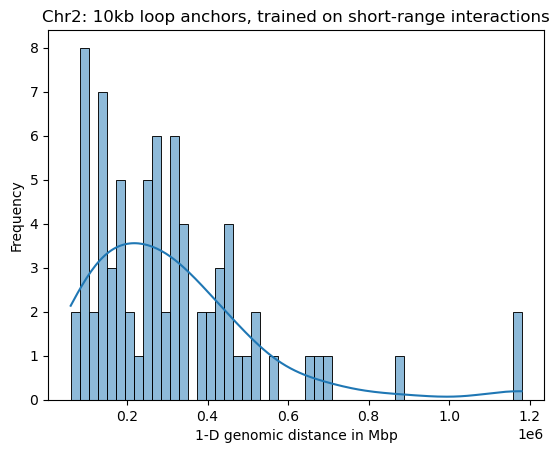

In [29]:
## collect called loops and convert into plotting format ##
loops_file = '/work/magroup/asachan2/genomic_hubs/peakachu/predicted_loops/GM12878-H3K27ac-chr2-loops.bedpe'
coords = parsebed(loops_file, lower=50000, upper=5000000) #(lower-upper): range of 1-d dist b/w anchors 
dist = loop1D_distance(coords, res=10000)
#print(dist)

#plot using seaborn
sns.histplot(dist, bins=50, kde=True)
plt.xlabel('1-D genomic distance in Mbp')
plt.ylabel('Frequency')
plt.title('Chr2: 10kb loop anchors, trained on short-range interactions')
plt.show()

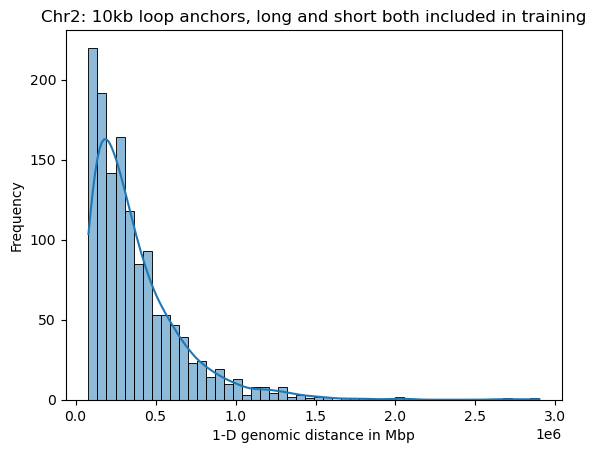

In [33]:
## collect called loops and convert into plotting format ##
loops_file = '/work/magroup/asachan2/genomic_hubs/peakachu/predicted_loops/CTCF_H3K27ac_GT.GM12878.hg19.peakachu-merged.loops'
coords = parsebed(loops_file, lower=50000, upper=5000000) #(lower-upper): range of 1-d dist b/w anchors 
chr2_coords = {'chr2': coords['chr2']}
dist = loop1D_distance(chr2_coords, res=10000)
#print(dist)

#plot using seaborn
sns.histplot(dist, bins=50, kde=True)
plt.xlabel('1-D genomic distance in Mbp')
plt.ylabel('Frequency')
plt.title('Chr2: 10kb loop anchors, long and short both included in training')
plt.show()

#### Loop calling using HICCUPS

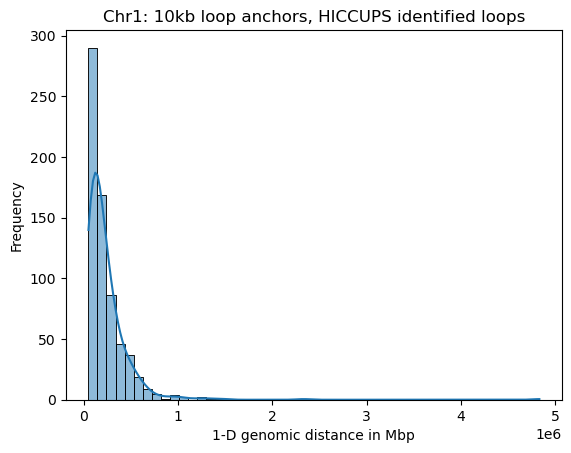

In [3]:
## collect HICCUPS called loops and convert into plotting format ##
loops_file = '/work/magroup/asachan2/genomic_hubs/juicer_tools/results/merged_loops.bedpe'
coords = parsebed(loops_file, lower=50000, upper=5000000) #(lower-upper): range of 1-d dist b/w anchors 
chr1_coords = {'chr1': coords['chr1']}
dist = loop1D_distance(chr1_coords, res=10000)
#print(dist)

#plot using seaborn
sns.histplot(dist, bins=50, kde=True)
plt.xlabel('1-D genomic distance in Mbp')
plt.ylabel('Frequency')
plt.title('Chr1: 10kb loop anchors, HICCUPS identified loops')
plt.show()

In [46]:
### comparing loop calls with GT ###

##### Loading loops into dfs #####
gt_file = '/work/magroup/asachan2/genomic_hubs/data/GM12878/GSE63525_GM12878_replicate_HiCCUPS_looplist.txt'
#header for this file already is present and the column names are chr1 x1 x2 chr2 y1 y2)
gt_loops = pd.read_csv(gt_file, sep='\t')
#extract first 6 columns which have both the loop anchors in bed format
gt_loops = gt_loops.iloc[:, :6]
#select for chr specific loops
gt_loops['chr1'] = gt_loops['chr1'].astype(str)
gt_loops = gt_loops[gt_loops['chr1'] == '1'] 

#load predicted loops for a single chr
pred_file = '/work/magroup/asachan2/genomic_hubs/juicer_tools/results/merged_loops.bedpe'
#header for this file already is present and the column names are chr1 x1 x2 chr2 y1 y2)
pred_loops = pd.read_csv(pred_file, sep='\t')
pred_loops = pred_loops.iloc[:, :6]

##### Making loops comparable by assigning them bins (same res) #####

#renaming the header columns from x1 x2 y1 y2 to start1 end1 start2 end2
gt_loops.columns = ['chr1', 'start1', 'end1', 'chr2', 'start2', 'end2']
pred_loops.columns = ['chr1', 'start1', 'end1', 'chr2', 'start2', 'end2']
#assigning bins to anchors
bins = c.bins().fetch('chr1')[:]
gt_loops = assign_bins_to_loops(gt_loops, bins)
pred_loops = assign_bins_to_loops(pred_loops, bins)
#print(pred_loops)
#print(gt_loops)
#compare the two dfs if bin_ids of the both the anchors coincide then the loops overlap (#of overlapping loops/#of total loops)
percent_overlap, coinciding_loops = compare_loops(gt_loops, pred_loops)
print("Percentage Overlap:", percent_overlap)
print("Overlapping Loops DataFrame:\n", coinciding_loops)

Percentage Overlap: 0.09615384615384616
Overlapping Loops DataFrame:
    chr1_x   start1_x     end1_x chr2_x   start2_x     end2_x    bin1   bin2_x  \
0       1   17050000   17060000      1  234910000  234920000  1706.0  23492.0   
1       1   26600000   26610000      1   26650000   26660000  2661.0   2666.0   
2       1   40610000   40620000      1   40800000   40810000  4062.0   4081.0   
3       1   40610000   40620000      1   40800000   40810000  4062.0   4081.0   
4       1   23810000   23820000      1   23860000   23870000  2382.0   2387.0   
..    ...        ...        ...    ...        ...        ...     ...      ...   
60      1   41230000   41240000      1   41410000   41420000     NaN      NaN   
61      1   89140000   89150000      1   89350000   89360000     NaN      NaN   
62      1  229980000  229990000      1  230300000  230310000     NaN      NaN   
63      1   54950000   54960000      1   55270000   55280000     NaN      NaN   
64      1  165360000  165370000      1 

* Using pre-computed loops at 10kb res for gm12878

In [8]:
## hic loops
file = 'data/GM12878/hg19_loops_peakachu/Rao_2014.GM12878.hg19.peakachu-merged.loops'
hic_loops = pd.read_csv(file, sep='\t', header=None, names=['chr1', 'start1', 'end1', 'chr2', 'start2', 'end2', 'score']) 
#extract first 6 columns which have both the loop anchors in bed format
hic_loops = hic_loops.iloc[:, :6]
#get the loops for specified chromosome 
hic_loops = hic_loops[hic_loops['chr1'] == chromosome]
print(hic_loops)
bins = c.bins().fetch(chromosome)[:]
hic_loops = assign_bins_to_loops(hic_loops, bins)
print(hic_loops)

       chr1     start1       end1  chr2     start2       end2
0      chr1  153480000  153490000  chr1  153720000  153730000
1      chr1  153480000  153490000  chr1  153950000  153960000
2      chr1  184040000  184050000  chr1  184630000  184640000
3      chr1  184040000  184050000  chr1  184190000  184200000
4      chr1  204530000  204540000  chr1  204730000  204740000
...     ...        ...        ...   ...        ...        ...
14501  chr1  172790000  172800000  chr1  173390000  173400000
14502  chr1  229790000  229800000  chr1  230400000  230410000
14503  chr1  221710000  221720000  chr1  222340000  222350000
14504  chr1    2540000    2550000  chr1    3340000    3350000
14505  chr1   70690000   70700000  chr1   71530000   71540000

[1620 rows x 6 columns]
       chr1     start1       end1  chr2     start2       end2   bin1   bin2
0      chr1  153480000  153490000  chr1  153720000  153730000  15349  15373
1      chr1  153480000  153490000  chr1  153950000  153960000  15349  15396
2  

* Using HiCAR loops/nodes at 10kb res

In [ ]:
### Generate bins bed file for the hg38.fa reference genome at the specified resolution (each chr binned separately) ###

import numpy as np
import pandas as pd
import os

chromsize_file = '/work/magroup/asachan2/genomic_hubs/data/hg38.autosomal.chrom.sizes'
#pass a list of resolutions you want to work with to create bed files
bin_reference_genome(chromsize_file, res=[10000], tmp_dir='tmp') 


10000 chr1
10000 chr2
10000 chr3
10000 chr4
10000 chr5
10000 chr6
10000 chr7
10000 chr8
10000 chr9
10000 chr10
10000 chr11
10000 chr12
10000 chr13
10000 chr14
10000 chr15


In [14]:
## HiCAR :: OCR loops for validating modules :: CHR specific ##

file = 'data/HiCAR_GM12878/GSM4977255_GM12787_HiCAR_interaction_MAPS_output_hg38.tsv'
ocr_loops = pd.read_csv(file, sep='\t') #file has header
#extract first 6 columns which have both the loop anchors in bed format
ocr_loops = ocr_loops.iloc[:, :6]
#get the loops for specified chromosome 
ocr_loops = ocr_loops[ocr_loops[chromosome] == chromosome]
print(ocr_loops)

####assign bins to anchors from reading bins in chr.bed files (10kb resolution)
chr_bin_file = 'tmp/10000_resolution/chr1.bed'
bins = pd.read_csv(chr_bin_file, sep='\t', header=None)
#add chrom start end header to the hg38 new bins
bins.columns = ['chrom', 'start', 'end']
ocr_loops = assign_bins_to_loops(ocr_loops, bins)
print(ocr_loops)

      chr1     start1       end1  chr2     start2       end2
0     chr1     980000     989999  chr1    1060000    1069999
1     chr1   22080000   22089999  chr1   22100000   22109999
2     chr1   27460000   27469999  chr1   27480000   27489999
3     chr1   39210000   39219999  chr1   39590000   39599999
4     chr1   36160000   36169999  chr1   36300000   36309999
...    ...        ...        ...   ...        ...        ...
4349  chr1  229650000  229659999  chr1  230300000  230309999
4350  chr1  229700000  229709999  chr1  230300000  230309999
4351  chr1  248700000  248709999  chr1  248790000  248799999
4352  chr1  248410000  248419999  chr1  248680000  248689999
4353  chr1  234140000  234149999  chr1  234320000  234329999

[4354 rows x 6 columns]
      chr1     start1       end1  chr2     start2       end2   bin1   bin2
0     chr1     980000     989999  chr1    1060000    1069999     99    107
1     chr1   22080000   22089999  chr1   22100000   22109999   2209   2211
2     chr1   27460

## Visualisation of hic and orthogonal data (juicebox++)

In [2]:
import juicebox_notebook

juicebox_notebook.init()
b = juicebox_notebook.Browser(
    { # load hic via URL
        "name": "GM12878",
        "locus": "2:3,319,567-30,009,566",
        "url": "https://www.encodeproject.org/files/ENCFF718AWL/@@download/ENCFF718AWL.hic",
        "normalization": "KR",
        "tracks": [
            { # load 1D track via URL
                "url": "https://www.encodeproject.org/files/ENCFF828CQV/@@download/ENCFF828CQV.bigWig",
                "name": "H3K4me2",
                "color": "rgb(22, 129, 198)"
            },
            { # load 1D track via URL
                "url": "https://www.encodeproject.org/files/ENCFF662QFK/@@download/ENCFF662QFK.bigWig",
                "name": "H3K36me3",
                "color": "rgb(122, 129, 198)"
            }
        ]
    }
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Graph construction using called edges and designed nodes

In [21]:
####### All edges are loaded ########

#whole genome contact matrix/edges as pandas df (reading as np array and not csr format as sparse=False)
#keeping balanced as true, not using raw counts
pixels = c.matrix(balance=True, sparse=False, as_pixels=True, join=False, divisive_weights=None)[:] 
#print(pixels.head())
edge_list = pixels[['bin1_id', 'bin2_id', 'balanced']].values #convert to numpy array
#remove self-loops (these are intra-chr, self-interactions)
edge_list = edge_list[edge_list[:,0]!=edge_list[:,1]]
#remove filtered bins (NAN values in balanced edges)
edge_list = edge_list[~np.isnan(edge_list[:,2])]
print(len(edge_list))

3972608


In [22]:
######### Loading only intra-chromosomal edges #########
#for 1Mb, only 223,829 (5.4%) of the total edges (3,972,608) are intra-chr. majority of edges are inter-chr.
#A2 = c.matrix().fetch('chr2', 'chr3') #inter edges; A3 = c.matrix().fetch('chr3:10M-20M', 'chr3:35M-40M') #intra edges

all_edges = c.matrix(balance=True, sparse=False, as_pixels=True, join=False, divisive_weights=None) #not a pd df
chr_edges = []
for i in range(22):
    chr = 'chr' + str(i+1)
    chr_edges.append(all_edges.fetch(chr, chr)[:])
chr_edges.append(all_edges.fetch('chrX', 'chrX')[:])
chr_edges.append(all_edges.fetch('chrY', 'chrY')[:])

#join all list items into one item
chr_edges = np.vstack(chr_edges)
#select column 0,1,3(balanced), 2 is for raw counts
chr_edges = chr_edges[:,[0,1,3]] 
#remove self-loops
chr_edges = chr_edges[chr_edges[:,0]!=chr_edges[:,1]]
#remove filtered bins
chr_edges = chr_edges[~np.isnan(chr_edges[:,2])]

print(len(chr_edges))

207836


In [23]:
###### loading chr-specific edges ########

chr1_edges = c.matrix(balance=True, sparse=False, as_pixels=True, join=False, divisive_weights=None).fetch('chr1', 'chr1')[:]
#convert to numpy array
chr1_edges = chr1_edges[['bin1_id', 'bin2_id', 'balanced']].values
#removing self loops
chr1_edges = chr1_edges[chr1_edges[:,0]!=chr1_edges[:,1]]
#remove filtered bins (Nans) in balanced
chr1_edges = chr1_edges[~np.isnan(chr1_edges[:,2])] 
print(len(chr1_edges))


24753


### 3D genomic edges

In [11]:
## Loops as edges (HiC): creating edge list for graph construction with bins1 and bin2 as nodes; sort the first edge column to have an increasing order of bin1 nodes

edges_loops = hic_loops[['bin1', 'bin2']]
edges_loops = edges_loops.sort_values(by='bin1')
edges_loops = edges_loops.reset_index(drop=True)
print(len(edges_loops))


1620


In [33]:
##### loading OE thresholded as edges #####

non_zero_indices = np.nonzero(OE_thresholded)
#weights = OE_thresholded[non_zero_indices]
#store the unique non-zero indices in a node list after flattening the 2D matrix
node_list = np.unique(np.concatenate((non_zero_indices[0], non_zero_indices[1])))
#create edges
oe_edges = list(zip(non_zero_indices[0], non_zero_indices[1]))
#print(oe_edges)

'''#get node labels from bins using this node_list from o/e edges
AB_label = bins.iloc[node_list]['a/b'].values
subC_label = bins.iloc[node_list]['subcompartment'].values
print(AB_label)
print(subC_label)'''


"#get node labels from bins using this node_list from o/e edges\nAB_label = bins.iloc[node_list]['a/b'].values\nsubC_label = bins.iloc[node_list]['subcompartment'].values\nprint(AB_label)\nprint(subC_label)"

### Node creation

{Only testing purposes: Bad idea to just stick to one dataset for node creation: extremely focused loops} Using loop anchors from HiCAR as nodes 

In [26]:
## using HiCAR OCR loop anchors as nodes (no labels about genes vs CREs) 
nodes_ocr = ocr_loops.iloc[:, -2:].values.flatten()
nodes_ocr = np.unique(nodes_ocr)
print(nodes_ocr)

[   99   107   113 ... 24882 24884 24888]


In [34]:
## loading o/e edges thresholded by ocr bins
nodes_set = set(nodes_ocr)
# Filter oe_edges to only include edges where both nodes are in nodes_to_filter
filtered_oe_edges = [edge for edge in oe_edges if edge[0] in nodes_set and edge[1] in nodes_set]
print(oe_edges[:5])
print(filtered_oe_edges[:5])

[(63, 254), (63, 255), (77, 22384), (77, 22385), (77, 22386)]
[(177, 365), (188, 365), (188, 366), (188, 367), (189, 365)]


{Test: prolly better results} Using ENCODE annotations as nodes

Graph creation and saving for visualisation

In [6]:
# Create a full graph 
G = nx.Graph()
G.add_weighted_edges_from(edge_list) #if slow use add_edges_from() after making a dictionary of norm_weights

In [ ]:
#create a intra-chr graph
G_chr = nx.Graph()
G_chr.add_weighted_edges_from(chr_edges)


In [17]:
#create a chr-specific graph
G_chr1 = nx.Graph()
G_chr1.add_weighted_edges_from(chr1_edges)

In [23]:
#O/E graph
G_OE_thresholded = nx.Graph()
G_OE_thresholded.add_weighted_edges_from(oe_edges)

#add node labels
#nx.set_node_attributes(G_OE_thresholded, dict(zip(node_list, AB_label)), 'A/B')
#nx.set_node_attributes(G_OE_thresholded, dict(zip(node_list, subC_label)), 'subcompartment')
nx.write_gexf(G_OE_thresholded, f"graphs/GM12878_{resolution}_{chromosome}_OE.gexf")

In [37]:
## filtered o/e graph
G_OE_OCR = nx.Graph()
G_OE_OCR.add_edges_from(filtered_oe_edges)
nx.write_gexf(G_OE_OCR, f"graphs/GM12878_{resolution}_{chromosome}_OE_OCR.gexf")

In [17]:
#loops graph
G_loops = nx.Graph()
#only add edges, ignore weights
G_loops.add_edges_from(edges_loops[['bin1', 'bin2']].values)
filtered_nodes = nodes_ocr
subG = G_loops.subgraph(filtered_nodes).copy()
nx.write_gexf(subG, f"graphs/GM12878_{resolution}_{chromosome}_loops_filtered.gexf")

In [ ]:
#combined graph (o/e + loops)

G_loops = nx.Graph()

# Assuming edges_loops is a DataFrame with columns 'bin1' and 'bin2'
for index, row in edges_loops.iterrows():
    G_loops.add_edge(row['bin1'], row['bin2'], edge_type='loop')

# Assuming oe_edges is a list of tuples or a DataFrame
if isinstance(oe_edges, list):
    for edge in oe_edges:
        G_loops.add_edge(edge[0], edge[1], edge_type='oe')
elif isinstance(oe_edges, pd.DataFrame):
    for index, row in oe_edges.iterrows():
        G_loops.add_edge(row[0], row[1], edge_type='oe')  # Adjust row indexing according to your data structure

# Filter nodes based on OCRs, assuming nodes_ocr is a list of node identifiers
filtered_nodes = nodes_ocr
subG = G_loops.subgraph(filtered_nodes).copy()

# Write to GEXF
nx.write_gexf(subG, f"graphs/GM12878_{resolution}_{chromosome}_combined.gexf")

[ ]  show # of clusters present in the graph
[ ]  size distribution of clusters (node degree plot?)
[ ]  Node identification: do tf motif analysis post-identification of hubs
[ ]  also could show node importance (meh)